In [18]:
# @title
# Setup
# https://pyod.readthedocs.io/en/latest/
# pyod for libraries in anomaly detection
#

# === CONFIGURATION ===
# Choose which dataset to use
DATASET_MODE = "cic-ids2018-wed14"
# options: "RT-IOT2022", "TON-IoT-Fridge"
# "cic-ids2018-fri02", "cic-ids2018-fri02-sub", "cic-ids2018-fri23",
# "cic-ids2018-thu01", "cic-ids2018-thu15", "cic-ids2018-thu22",
# "cic-ids2018-wed14", "cic-ids2018-wed21", "cic-ids2018-wed28"


# Enable lightweight mode to avoid OOM
LIGHT_MODE = False          # set False for full data
CHUNK_SIZE = 20000         # adjust for Colab (50k–100k recommended)
SAMPLE_LIMIT = 200000



In [19]:
# Setup
!pip3 install -U pyod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, roc_auc_score
)
from sklearn import tree

from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print

In [20]:

if DATASET_MODE == "RT-IOT2022":
    !pip3 install -U ucimlrepo
    from ucimlrepo import fetch_ucirepo

    dataset = fetch_ucirepo(id=942)
    X = dataset.data.features
    y = dataset.data.targets
    benign_labels = ['Thing_Speak', 'MQTT_Publish', 'NMAP_XMAS_TREE_SCAN', 'NMAP_TCP_scan',
                 'NMAP_OS_DETECTION', 'NMAP_UDP_SCAN', 'Wipro_bulb', 'NMAP_FIN_SCAN',
                 'DOS_SYN_Hping']
    malicious_column = "Attack_type"
    EXCLUDE_FROM_SCALING = []
    #benign_labels = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb',
    #                 'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    #                 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN']


elif DATASET_MODE.startswith("cic-ids2018-"):
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']
    if DATASET_MODE == "cic-ids2018-fri02":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-fri02-sub":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.subset.csv"
    elif DATASET_MODE == "cic-ids2018-fri23":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu01":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu15":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-thu22":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed14":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed21":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv"
    elif DATASET_MODE == "cic-ids2018-wed28":
      filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv"


    df =  pd.read_csv(filename, low_memory=True)
    # Attempt to parse timestamp automatically
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

    # Extract hour, minute, and second
    df["hour"] = df["Timestamp"].dt.hour.fillna(0)
    df["minute"] = df["Timestamp"].dt.minute.fillna(0)
    df["second"] = df["Timestamp"].dt.second.fillna(0)

    # Compute cyclical time features
    df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
    df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

    # Drop timestamp and raw time components (keep only sin/cos)
    df = df.drop(columns=["Timestamp", "hour", "minute", "second"])

    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]] if malicious_column in df.columns else None
    print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "TON-IoT-Fridge":
  benign_labels = False
  malicious_column = "label"
  EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

  filename = "/content/drive/MyDrive/datasets-anomaly-detection/TON-IoT/Train_Test_IoT_Fridge.csv"
  df = pd.read_csv(filename, low_memory=True)
  df["Timestamp"] = pd.to_datetime(df["time"], errors="coerce")

  # Extract hour, minute, and second
  df["hour"] = df["Timestamp"].dt.hour.fillna(0)
  df["minute"] = df["Timestamp"].dt.minute.fillna(0)
  df["second"] = df["Timestamp"].dt.second.fillna(0)

  # Compute cyclical time features
  df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
  df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

  # Drop timestamp and raw time components (keep only sin/cos)
  df = df.drop(columns=["Timestamp", "hour", "minute", "second", "time", 'date', 'type'])

  df['temp_condition'] = df['temp_condition'].astype(str).str.strip()

  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "KKDCup-10":
  benign_labels = "normal."
  malicious_column = "label"
  EXCLUDE_FROM_SCALING = ['label', 'time_sin', 'time_cos']
  filename = "/content/drive/MyDrive/datasets-anomaly-detection/kddcup/kddcup.data_10_percent_corrected.csv"
  df = pd.read_csv(filename, low_memory=True)
  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Initial column names: {X.columns.values}")


/tmp/ipython-input-3352949519.py:44: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")


Loaded chunk shape: (1048575, 81)
X shape: (1048575, 80)
y shape: (1048575, 1)
Initial column names: ['Dst Port' 'Protocol' 'Flow Duration' 'Tot Fwd Pkts' 'Tot Bwd Pkts'
 'TotLen Fwd Pkts' 'TotLen Bwd Pkts' 'Fwd Pkt Len Max' 'Fwd Pkt Len Min'
 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std' 'Bwd Pkt Len Max' 'Bwd Pkt Len Min'
 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std' 'Flow Byts/s' 'Flow Pkts/s'
 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max' 'Flow IAT Min'
 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max' 'Fwd IAT Min'
 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max' 'Bwd IAT Min'
 'Fwd PSH Flags' 'Bwd PSH Flags' 'Fwd URG Flags' 'Bwd URG Flags'
 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s' 'Pkt Len Min'
 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var' 'FIN Flag Cnt'
 'SYN Flag Cnt' 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt'
 'URG Flag Cnt' 'CWE Flag Count' 'ECE Flag Cnt' 'Down/Up Ratio'
 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg' 'Fwd Byts/b Avg'
 '

In [21]:
X.head(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,time_sin,time_cos
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,0.790645,-0.612275
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,0.783061,-0.621945
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,0.775358,-0.631522
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,0.0,0.0,0,0,0.0,0.000000,0,0,0.765436,-0.643512
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,0.0,0.0,0,0,0.0,0.000000,0,0,0.764968,-0.644068
5,22,6,6989341,16,12,1239,2273,744,0,77.437500,...,0.0,0.0,0,0,0.0,0.000000,0,0,0.764593,-0.644513
6,0,0,112640480,3,0,0,0,0,0,0.000000,...,0.0,0.0,0,0,56320240.0,203.646753,56320384,56320096,0.767538,-0.641003
7,0,0,112641244,3,0,0,0,0,0,0.000000,...,0.0,0.0,0,0,56320622.0,62.225397,56320666,56320578,0.759602,-0.650388
8,80,6,476513,5,3,211,463,211,0,42.200000,...,0.0,0.0,0,0,0.0,0.000000,0,0,0.745379,-0.666641
9,80,6,475048,5,3,220,472,220,0,44.000000,...,0.0,0.0,0,0,0.0,0.000000,0,0,0.745331,-0.666695


In [22]:

# TODO: drop NaN or invalid
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]



num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns
# Identify time features to exclude from scaling

# Automatically exclude only those that exist
excluded_features = [col for col in EXCLUDE_FROM_SCALING if col in num_cols]
num_cols_to_scale = [col for col in num_cols if col not in excluded_features]

if len(X) < 5e5:
    log_transformer = FunctionTransformer(lambda arr: np.log1p(np.abs(arr)))
else:
    log_transformer = FunctionTransformer(lambda arr: arr)  # passthrough for big data

numeric_transformer = Pipeline([
    ('log', log_transformer),
    ('scaler', RobustScaler(quantile_range=(5, 95)))
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Define preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols_to_scale),
    ("passthrough", "passthrough", excluded_features),
    ("cat", categorical_transformer, cat_cols)
])

# Fit on a sample to reduce memory if data huge
sample_rows = min(SAMPLE_LIMIT, len(X))
preprocessor.fit(X.sample(sample_rows, random_state=42))

if LIGHT_MODE:
  # Transform in smaller batches
  def transform_in_chunks(preprocessor, X, chunk_size=CHUNK_SIZE):
      chunks = []
      for i in range(0, len(X), chunk_size):
          X_chunk = X.iloc[i:i+chunk_size]
          X_trans = preprocessor.transform(X_chunk)
          chunks.append(X_trans)
      return np.vstack([c.toarray() if hasattr(c, "toarray") else c for c in chunks])
  print("Transform")
  # Apply transformation safely
  X_scaled = transform_in_chunks(preprocessor, X)
else:
# Apply transformations
  X_scaled = preprocessor.transform(X)

# print(np.min(X_scaled), np.max(X_scaled))
# print(np.mean(X_scaled), np.std(X_scaled))


# Get proper column names
num_features = np.array(num_cols)
cat_features = np.array([])
if len(cat_cols) > 0:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])


# Construct final DataFrame
X = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")
print(f"Final feature count: {X.shape[1]}")
print(X.head())

print(cat_cols)
print(X.shape)
print(y.shape)



Numeric cols: 80, Categorical cols: 0
Final feature count: 80
   Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0 -0.001050 -0.545455       1.433455      0.047619     -0.045455   
1 -0.001050 -0.545455       1.433452      0.047619     -0.045455   
2 -0.001050 -0.545455       1.433416      0.047619     -0.045455   
3 -0.000614  0.000000       0.082119      0.619048      0.409091   
4 -0.000614  0.000000       0.112027      0.571429      0.454545   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
0        -0.018672        -0.014799        -0.051699              0.0   
1        -0.018672        -0.014799        -0.051699              0.0   
2        -0.018672        -0.014799        -0.051699              0.0   
3         0.623963         0.585888         1.047267              0.0   
4         0.574170         0.568975         1.047267              0.0   

   Fwd Pkt Len Mean  ...  Active Mean  Active Std  Active Max  Active Min  \
0         -0.

In [23]:
if benign_labels:
    y_binary = y[malicious_column].apply(lambda v: 0 if v.strip() in benign_labels else 1)
    print(f"Benign: {(y_binary == 0).sum()} | Anomaly: {(y_binary == 1).sum()}")
else:
    y_binary = y[malicious_column]
# print the labels for benign and non-benign attacks
print(benign_labels)
# print the labels that are not benign, ie.e malicious
print(y_binary.unique())

contamination_ratio = (y_binary == 1).sum() / ((y_binary == 1).sum() + (y_binary == 0).sum())
print(f"Anomaly ratio for full data: {contamination_ratio}")

# Split benign data into training and test sets Thing_Speak
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.40, random_state=4
)

# Combine benign test data and malicious data for the overall test set
# X_test = pd.concat([X_test_benign, X.loc[y_malicious.index]])
# y_test = pd.concat([y_test_benign, y_malicious])


Benign: 663808 | Anomaly: 380943
['Benign']
[0 1]
Anomaly ratio for full data: 0.3646256380706982


In [24]:
# Get the original labels that are not in the benign_labels list
malicious_labels = y[y_binary == 1][malicious_column].unique()

print("Malicious attack types:")
print(malicious_labels)

Malicious attack types:
['FTP-BruteForce' 'SSH-Bruteforce']


In [25]:
clf_name = 'IForest'

max_samples = 0.02
# ensure min number of samples is at least 1
if isinstance(max_samples, float):
    max_samples = max(256, int(max_samples * X_train.shape[0]))

clf = IForest(random_state=5, n_estimators=500, contamination=min(0.5, max(0.02, contamination_ratio)),
              max_samples=max_samples, behaviour='new')
print(clf.get_params())
clf.fit(X_train)

{'behaviour': 'new', 'bootstrap': False, 'contamination': np.float64(0.3646256380706982), 'max_features': 1.0, 'max_samples': 12537, 'n_estimators': 500, 'n_jobs': 1, 'random_state': 5, 'verbose': 0}


IForest(behaviour='new', bootstrap=False,
    contamination=np.float64(0.3646256380706982), max_features=1.0,
    max_samples=12537, n_estimators=500, n_jobs=1, random_state=5,
    verbose=0)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(



Evaluation On Training Data:
IForest ROC:0.3259, precision @ rank n:0.223

Evaluation On Test Data:
IForest ROC:0.3242, precision @ rank n:0.2263
['Dst Port' 'Protocol' 'Flow Duration' 'Tot Fwd Pkts' 'Tot Bwd Pkts'
 'TotLen Fwd Pkts' 'TotLen Bwd Pkts' 'Fwd Pkt Len Max' 'Fwd Pkt Len Min'
 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std' 'Bwd Pkt Len Max' 'Bwd Pkt Len Min'
 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std' 'Flow Byts/s' 'Flow Pkts/s'
 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max' 'Flow IAT Min'
 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max' 'Fwd IAT Min'
 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max' 'Bwd IAT Min'
 'Fwd PSH Flags' 'Bwd PSH Flags' 'Fwd URG Flags' 'Bwd URG Flags'
 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s' 'Pkt Len Min'
 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var' 'FIN Flag Cnt'
 'SYN Flag Cnt' 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt'
 'URG Flag Cnt' 'CWE Flag Count' 'ECE Flag Cnt' 'Down/Up Ratio'
 'Pkt Size Avg' 'Fwd Seg Si

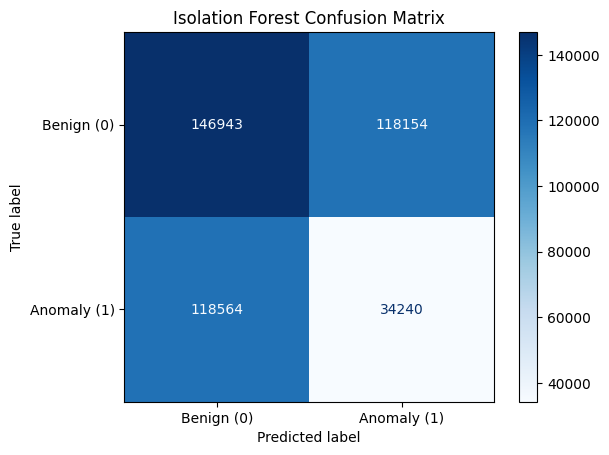


Classification Report:
              precision    recall  f1-score   support

      Benign       0.55      0.55      0.55    265097
     Anomaly       0.22      0.22      0.22    152804

    accuracy                           0.43    417901
   macro avg       0.39      0.39      0.39    417901
weighted avg       0.43      0.43      0.43    417901

Number of trees: 500


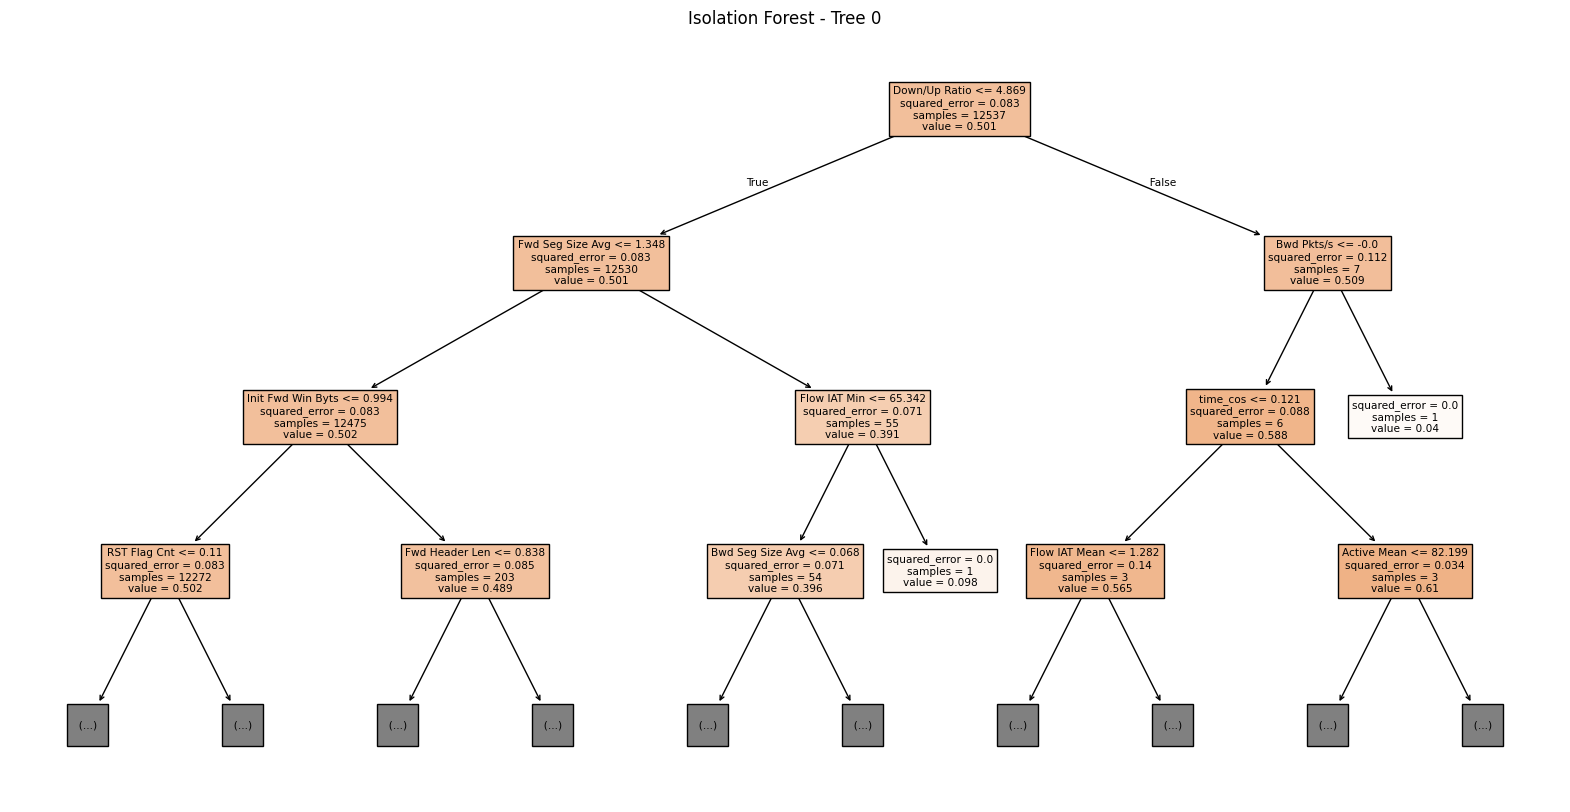

In [26]:
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nEvaluation On Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)

print("\nEvaluation On Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print(feature_names)
for i, v in enumerate(feature_importance):
    print(f'Feature: {feature_names[i]}, Score: {v:.5f}')
print("Feature importance", feature_importance)


# Sort and display top 10 features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 features by importance:")
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s} {row['Importance']:.6f}")
# Features with no importance
print("\nFeatures with no importance:")
for i, row in importance_df[importance_df['Importance'] == 0].iterrows():
    print(f"{i+1:2d}. {row['Feature']:30s} {row['Importance']:.6f}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display as text
print("\nConfusion Matrix:")
print(cm)

# Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Anomaly (1)"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Isolation Forest Confusion Matrix")
plt.show()

# Classification report for precision, recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Anomaly"]))

sklearn_iforest = clf.detector_  # The underlying sklearn IsolationForest
trees = sklearn_iforest.estimators_
print(f"Number of trees: {len(trees)}")

plt.figure(figsize=(20, 10))
tree.plot_tree(
    trees[0],  # visualize the first tree
    filled=True,
    feature_names=X.columns,
    max_depth=3  # limit depth for readability
)
plt.title("Isolation Forest - Tree 0")
plt.show()




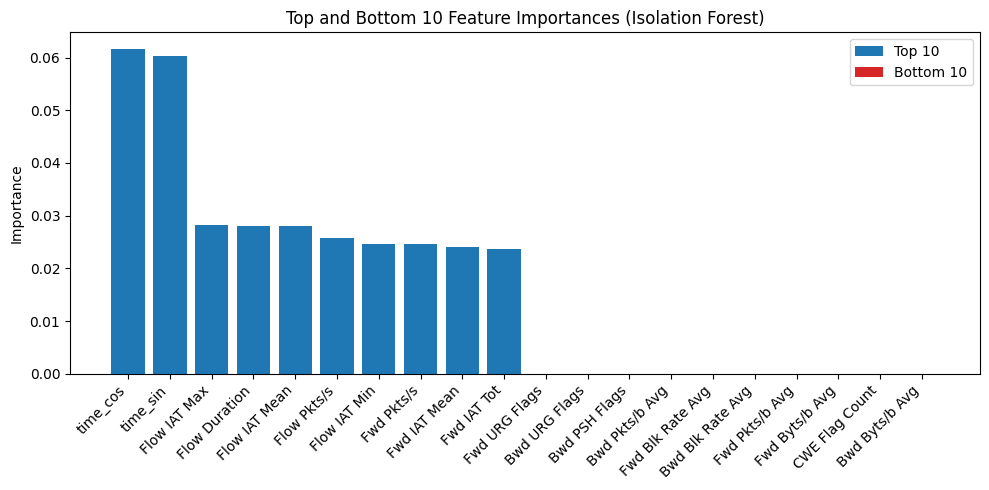

In [27]:
# Plot
plt.figure(figsize=(10, 5))

# Combine both in one bar chart
plt.bar(importance_df.head(10)["Feature"], importance_df.head(10)["Importance"], color="tab:blue", label="Top 10")
plt.bar(importance_df.tail(10)["Feature"], importance_df.tail(10)["Importance"], color="tab:red", label="Bottom 10")

plt.title("Top and Bottom 10 Feature Importances (Isolation Forest)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.legend()
plt.tight_layout()
plt.show()


Top 5 most anomalous samples:


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Idle Min,time_sin,time_cos,score,label
984708,0.007724,0.0,0.000010,0.0,-0.045455,...,0.0,0.567245,-0.823549,-0.027645,0
1010003,0.007724,0.0,0.000010,0.0,-0.045455,...,0.0,0.548536,-0.836127,-0.027645,0
615213,0.007724,0.0,0.000067,0.0,-0.045455,...,0.0,0.548354,-0.836246,-0.027645,0
999265,0.007724,0.0,0.000029,0.0,-0.045455,...,0.0,0.513292,-0.858214,-0.027644,0
393944,0.000535,0.0,0.000001,0.0,-0.045455,...,0.0,0.527512,-0.849548,-0.027637,0


Top 10 feature deviations for this anomaly:
ACK Flag Cnt       1.000000
PSH Flag Cnt       1.000000
Bwd Pkt Len Max    0.682517
Pkt Len Max        0.682517
Pkt Size Avg       0.513237
Pkt Len Mean       0.511405
Pkt Len Std        0.507822
Fwd Pkt Len Max    0.500739
Bwd Pkt Len Std    0.497118
Fwd Pkt Len Std    0.424809
dtype: float64


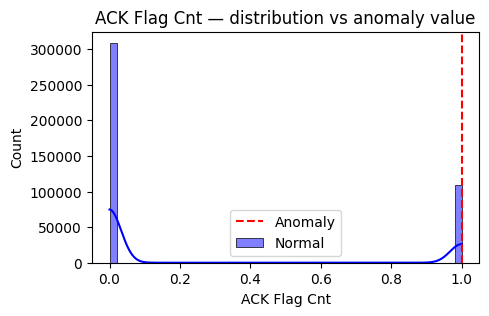

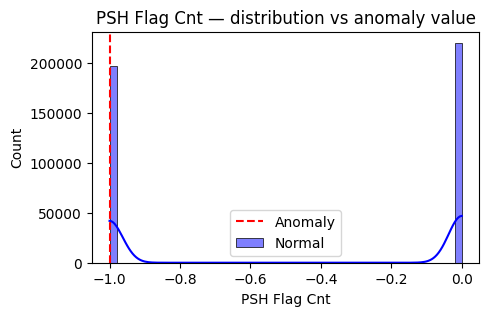

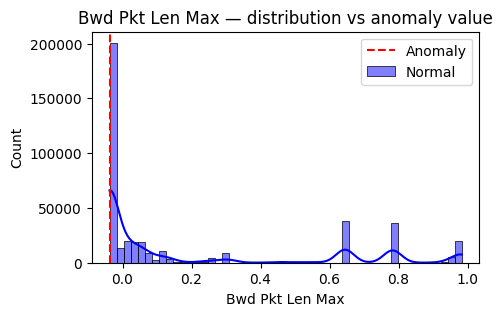

In [28]:
# Lower scores = more anomalous
X_test_anomalies = X_test.copy()
X_test_anomalies["score"] = y_test_scores
X_test_anomalies["label"] = y_test_pred

# Sort anomalies by score (lowest first)
top_anomalies = X_test_anomalies.sort_values(by="score", ascending=True).head(5)
print("Top 5 most anomalous samples:")
display(top_anomalies)

# Compute median of normal samples for reference
normal_median = X_test[y_test_pred == 1].median()

# Pick one example anomaly
anomaly_idx = top_anomalies.index[0]
anomaly = X_test.loc[anomaly_idx]

# Compute deviation from normal behavior
deviation = (anomaly - normal_median).abs().sort_values(ascending=False)
print("Top 10 feature deviations for this anomaly:")
print(deviation.head(10))

import seaborn as sns

top_features = deviation.head(3).index  # 3 most deviating features

for feature in top_features:
    plt.figure(figsize=(5,3))
    sns.histplot(X_test[feature], bins=50, kde=True, color="blue", label="Normal")
    plt.axvline(anomaly[feature], color="red", linestyle="--", label="Anomaly")
    plt.title(f"{feature} — distribution vs anomaly value")
    plt.legend()
    plt.show()



